# Training Neural Networks

To find a network's parameters, we need to know how poorly the network is predicting the real outputs. For this we calculate a **loss function** (also called the cost), a measure of our prediction error. For example, the mean squared loss is often used in regression and binary classification problems

$$
\large \ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

where $n$ is the number of training examples, $y_i$ are the true labels, and $\hat{y}_i$ are the predicted labels.

## Backpropagation

For single layer networks, gradient descent is straightforward to implement. However, it's more complicated for deeper, multilayer neural networks like the one we've built. Complicated enough that it took about 30 years before researchers figured out how to train multilayer networks.

Training multilayer networks is done through **backpropagation** which is really just an application of the chain rule from calculus. It's easiest to understand if we convert a two layer network into a graph representation.

<img src='assets/backprop_diagram.png' width=550px>

$$
\large \frac{\partial \ell}{\partial W_1} = \frac{\partial L_1}{\partial W_1} \frac{\partial S}{\partial L_1} \frac{\partial L_2}{\partial S} \frac{\partial \ell}{\partial L_2}
$$

We update our weights using this gradient with some learning rate $\alpha$. 

$$
\large W^\prime_1 = W_1 - \alpha \frac{\partial \ell}{\partial W_1}
$$

The learning rate $\alpha$ is set such that the weight update steps are small enough that the iterative method settles in a minimum.

# Training a NN

**RECALL:**

Mini-batch Gradient Descebt: [GD-variants.pptx]
```python
Initialize theta
for epoch in range(N_epochs):
    Shuffle(training_data)
    for i in range(0,N,batch_size): # N: number of training data
        batch = training_data[i:i+batch_size] 
        grad = evaluate_gradient(loss,theta,batch)
        eta = learning_schedule(epoch)
        theta = theta - eta*grad
```


> Exercise: Implement the training pass for a network. If you implemented it correctly, you should see the training loss drop with each epoch. 

In [1]:
import torch
from torch import nn
from torch import optim

import torch.nn.functional as F
from torchvision import datasets, transforms

## Prepare dataset

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

## Define the model

In [3]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10)).cuda()

In [4]:
if torch.cuda.is_available():
    my_device = torch.device('cuda')
else:
    my_device = torch.device('cpu')
print('Device: {}'.format(my_device))

model.to(my_device)

Device: cuda


Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
)

In [5]:
criterion = nn.CrossEntropyLoss()  # By default, reduction = 'mean'. 
# Hence, loss.item() contains the loss of entire mini-batch, but divided by the batch size.

optimizer = optim.SGD(model.parameters(), lr=0.003)

Training

**Note:** 

If you use GPU (either using `model.to('cuda')` or `model.cuda()`), It is required to move the loaded data and labels to GPU.

Example: 

Instead of `output = model(images)`, use `output = model(images.to('cuda'))`.

In [6]:
epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        
        # Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()
        
        # Forward pass, get our logits
        output = model(images.to(my_device)) # output = model(images) CAUSES ERROR
        
        # Calculate the loss with the logits and the labels
        loss = criterion(output, labels.to(my_device)) # loss = criterion(output, labels) CAUSES ERROR
        
        # backward pass through the operations that created loss
        loss.backward()
        
        # Take an update step
        optimizer.step()
        
        running_loss += loss.item()*images.shape[0]
    else:
        print(f"Training loss: {running_loss/len(trainloader.dataset)}")

Training loss: 1.9329210791905722
Training loss: 0.878707010682424
Training loss: 0.5405897535641988
Training loss: 0.43724528576533
Training loss: 0.39004647526741026


`optimizer.zero_grad()`: When you do multiple backwards passes with the same parameters, the gradients are accumulated. This means that you need to zero the gradients on each training pass or you'll retain gradients from previous training batches.

# Prediction

tensor([[-2.7412, -2.7696, -0.6944,  0.7767,  1.0533,  0.0689, -3.6214,  5.9623,
          0.1455,  4.9425]], device='cuda:0')
tensor([[1.2021e-04, 1.1683e-04, 9.3068e-04, 4.0525e-03, 5.3437e-03, 1.9967e-03,
         4.9849e-05, 7.2409e-01, 2.1557e-03, 2.6115e-01]], device='cuda:0')


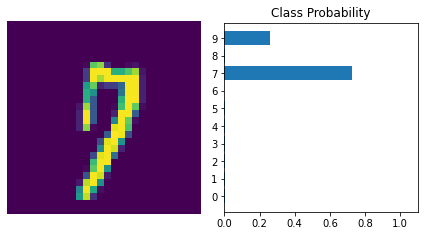

In [13]:
%matplotlib inline
import helper

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    scores = model(img.to(my_device))

print(scores)
print(nn.Softmax(dim=1)(scores))

helper.view_classify(img.cpu().view(1, 28, 28), nn.Softmax(dim=1)(scores.cpu()))